# Library Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import random


# Item Selection

I selected all the assets that had data from 2008-01-01 among the S&P500 stock list.

In [40]:
#path = 'C:\\Users\\prana\\Documents\\DS 340W\\Selected_Stocks' 
path = 'C:\\Users\\prana\\Documents\\DS 340W\\Random_Stocks'
stock08 = []
for file in os.listdir(path):
    file_path = path + '/' + file
    date = pd.read_csv(file_path)['Date']
    #if len(date)>0 and pd.read_csv(file_path)['Date'][0] <= '2008-01-01' :
    stock08.append(file)
print(str(len(stock08))+" stocks selected")
print(stock08)

10 stocks selected
['AXP.csv', 'BBY.csv', 'CAG.csv', 'EMR.csv', 'HSY.csv', 'INCY.csv', 'MCK.csv', 'MNST.csv', 'TGT.csv', 'WBA.csv']


# Organize Data

In order to keep concise and deal with missing data, I concatenated all the price data of the selected items above to a single dataframe

In [41]:
stock_price_dict = {}

for file in stock08 :
    path = 'C:\\Users\\prana\\Documents\\DS 340W\\Random_Stocks\\' + file
    df = pd.read_csv(path)
    pd.to_datetime(df['Date'])
    df = df.set_index(pd.DatetimeIndex(df['Date']))
    stock_price_dict[file.split(".")[0]] = df['Close']

#market_path = "C:\\Users\\prana\\Documents\\DS 340W\\SP500_index2.csv"
market_path = "C:\\Users\\prana\\Documents\\DS 340W\\nasdaq_index.csv"
df = pd.read_csv(market_path)
pd.to_datetime(df['Date'])
df = df.set_index(pd.DatetimeIndex(df['Date']))
#stock_price_dict['NASDAQ'] = df['Close']
stock_price_dict['SP500'] = df['Close']
    
stock_price_df = pd.DataFrame(stock_price_dict)

In [42]:
print(stock_price_df.head())

                  AXP        BBY        CAG        EMR        HSY       INCY  \
Date                                                                           
2013-08-30  71.910004  36.000000  26.319065  60.369999  91.949997  33.889999   
2013-09-03  72.430000  36.990002  26.381323  60.700001  91.040001  34.250000   
2013-09-04  73.139999  37.139999  26.350195  61.330002  90.989998  34.580002   
2013-09-05  73.800003  37.490002  26.319065  61.669998  90.190002  35.169998   
2013-09-06  73.349998  37.020000  26.225681  61.470001  90.739998  35.619999   

                   MCK       MNST        TGT        WBA        SP500  
Date                                                                  
2013-08-30  121.410004  19.129999  63.310001  48.070000  3589.870117  
2013-09-03  122.519997  18.006666  63.590000  48.740002  3612.610107  
2013-09-04  123.000000  18.683332  63.549999  49.490002  3649.040039  
2013-09-05  122.940002  18.713333  63.459999  50.189999  3658.780029  
2013-09-06  1

# Dealing with Missing Data

In [43]:
NA_col = []
NA_ratio = []
for col in stock_price_df.columns :
    na_index = np.where(stock_price_df[col].isnull())[0]
    NA_col.append(col)
    NA_ratio.append(len(na_index)/stock_price_df.shape[0] * 100)
    print(col,na_index)
NA_df = pd.DataFrame({'tickers':NA_col,'NA_ratio':NA_ratio})


AXP []
BBY []
CAG []
EMR []
HSY []
INCY []
MCK []
MNST []
TGT []
WBA []
SP500 []


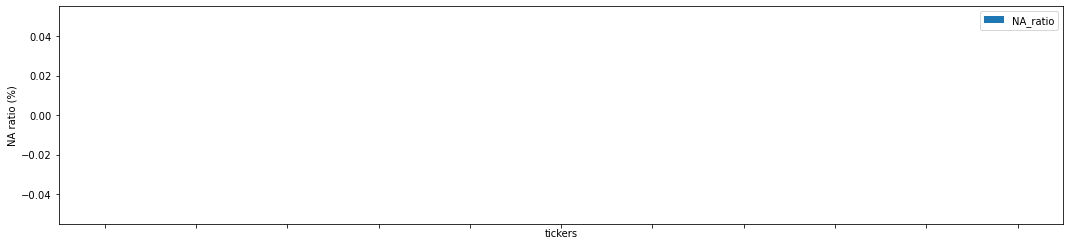

In [44]:
NA_df.plot.bar(rot=0, figsize=(18,4))
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
plt.xlabel('tickers')
plt.ylabel('NA ratio (%)')
plt.show()
plt.close()

Most of the dataset that has missing data has only one or two data points missing. It would be rational enough to impute the data points with the data from the day right before.

However, one company has quite some missing data. 'MMM' is the only company that has high proportion of missing data. Leaving out this one company from the S&P 500 firms wouldn't be a big issue. So I'll drop the 'MMM' column the dataframe

In [45]:
def impute_data(column_name):
    index = stock_price_df.index.values[0]
    price_na_index = np.where(stock_price_df[column_name].isnull())[0]
    for i in price_na_index :
        stock_price_df[column_name][i] = stock_price_df[column_name][i-1]

In [46]:
for item in stock_price_df.columns :
    impute_data(item)

In [47]:
# Final Check for NaN
for item in stock_price_df.columns :
    if stock_price_df[item].isnull().values.any() :
        print('stock price data of '+item+' still has NaN')
print("END OF CHECKING. NO NA REMAINING")

END OF CHECKING. NO NA REMAINING


In [48]:
stock_price_df.to_csv("C:\\Users\\prana\\Documents\\DS 340W\\stock08_price.csv",index_label='Date')

# Create Portfolio

out of 505 companies, 150 firms are randomly selected for the portfolio.

In [50]:
df = pd.read_csv("C:\\Users\\prana\\Documents\\DS 340W\\stock08_price.csv")
universe = list(df.columns.values[1:])
#universe.remove("NASDAQ")
universe.remove("SP500")
print(universe)

['AXP', 'BBY', 'CAG', 'EMR', 'HSY', 'INCY', 'MCK', 'MNST', 'TGT', 'WBA']


In [54]:
#FOR LIST REUSE#FOR LIS 
#portfolio = ['AMGN', 'ATVI', 'COST', 'GILD', 'MDLZ', 'PEP', 'REGN', 'VRTX', 'WBA', 'XEL']
portfolio = ['AXP', 'BBY', 'CAG', 'EMR', 'HSY', 'INCY', 'MCK', 'MNST', 'TGT', 'WBA']

# Prepare the Data

In [55]:
def rolling_corr(item1,item2) :
    #import data
    stock_price_df = pd.read_csv("C:\\Users\\prana\\Documents\\DS 340W\\stock08_price.csv")
    pd.to_datetime(stock_price_df['Date'], format='%Y-%m-%d')
    stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['Date']))
    
    #calculate
    df_pair = pd.concat([stock_price_df[item1], stock_price_df[item2]], axis=1)
    df_pair.columns = [item1,item2]
    df_corr = df_pair[item1].rolling(window=100).corr(df_pair[item2])
    return df_corr


In [56]:
index_list = []
for _ in range(100):
    indices = []
    for k in range(_, 2100,100):
        indices.append(k)
    index_list.append(indices)

data_matrix = []
count = 0
stocks_a = []
stocks_b = []

for i in range(10):
    for j in range(9-i):
        a = portfolio[i]
        b = portfolio[9-j]
        file_name = a + '_' + b
        stocks_a.append(a)
        stocks_b.append(b)
            
        corr_series = rolling_corr(a, b)[99:]
        for j in range(1):
            corr_strided = list(corr_series[index_list[j]][:21]).copy()
            data_matrix.append(corr_strided)
            count+=1
            if count % 1000 == 0 :
                print(str(count)+' items preprocessed')

data_matrix = np.transpose(data_matrix)
data_dictionary = {}
for i in range(len(data_matrix)):
    data_dictionary[str(i)] = data_matrix[i]
data_df = pd.DataFrame(data_dictionary)
data_df.to_csv("dataset.csv")

In [57]:
stock_pairs = pd.DataFrame(stocks_a, stocks_b).reset_index()
stock_pairs.columns = ["stock1", "stock2"]
stock_pairs.to_csv("stock_pairs.csv", index=False)